## HeatMap for CNN

reference: https://blog.csdn.net/weixin_43960370/article/details/136874709

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import gvp.MSCSolmodel
import torch
import torch.autograd as autograd
device = torch.device('cpu')
print('device', device)
import torch
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False  

def draw_cam(model, img_path, save_path, transform=None):
    img = Image.open(img_path).convert('RGB')
    if transform is not None:
        img = transform(img)
    img = img.unsqueeze(0)
    img = img.to(device)
    model.eval()
    x = model.resnet18.conv1(img)
    x = model.resnet18.bn1(x)
    x = model.resnet18.act1(x)
    x = model.resnet18.maxpool(x)
    x = model.resnet18.layer1(x)
    x = model.resnet18.layer2(x)
    x = model.resnet18.layer3(x)
    x = model.resnet18.layer4(x)
    features = x              
    print(features.shape)
    output = model.resnet18.global_pool(features)
    features_flatten = torch.flatten(output, 1)
    output = model.resnet18.fc(features_flatten)
    output = model._resnetrelu1(output)
    output = model._resnetpred4(output)
    output = model._resnetrelu2(output)
    output = model._resnetpred5(output)

    pred = torch.argmax(output, 1).item()
    pred_class = output[:, pred]
 
    features_grad = autograd.grad(pred_class, features, allow_unused=True)[0]
 
    grads = features_grad 
    pooled_grads = torch.nn.functional.adaptive_avg_pool2d(grads, (1, 1))

    pooled_grads = pooled_grads[0]
    features = features[0]
    print("pooled_grads:", pooled_grads.shape)
    print("features:", features.shape)

    for i in range(features.shape[0]):
        features[i, ...] *= pooled_grads[i, ...]
 
    # 计算heatmap
    heatmap = features.detach().cpu().numpy()
    heatmap = np.mean(heatmap, axis=0)
    heatmap = np.maximum(-heatmap, 0)
    heatmap /= np.max(heatmap)

    img = cv2.imread(img_path) 
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0])) 
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) 
    img_hsv=cv2.cvtColor(img,cv2.COLOR_RGB2HSV) 
    xishu=70/img_hsv[:,:,2].mean() 
    img_hsv[:,:,2]=img_hsv[:,:,2]*xishu 
    img1=cv2.cvtColor(img_hsv,cv2.COLOR_HSV2RGB) 
    superimposed_img = heatmap * 0.4 + img1 
    cv2.imwrite(save_path, superimposed_img) 


from torchvision import transforms
test_transform = transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])


model = gvp.MSCSolmodel.CNN_only("skresnext50_32x4d").to(device)
model.load_state_dict(torch.load('./pic/SKA.pt'))
for i in ["test"]:
    draw_cam(model, './pic/'+str(i)+'.png',
         './pic/'+str(i)+'.png', transform=test_transform)

device cpu
torch.Size([1, 2048, 7, 7])
pooled_grads: torch.Size([2048, 1, 1])
features: torch.Size([2048, 7, 7])


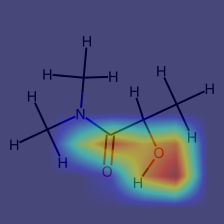

In [1]:
from IPython.display import Image
Image('./pic/test.png')